## 1. Load the Dataset and preview

In [2]:
import pandas as pd

# Load the processed dataset
df = pd.read_csv("../artifacts/processed_data.csv")

# Show shape and a sample
print("Data Shape:", df.shape)
df.head()

Data Shape: (8914963, 38)


,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,...,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,mcc_desc
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,...,Female,594 Mountain View Street,46.80,-100.76,$23679,$48277,$110153,740,4,Miscellaneous Food Stores
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,...,Male,604 Pine Street,40.80,-91.12,$18076,$36853,$112139,834,5,Department Stores
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,...,Male,2379 Forest Lane,33.18,-117.29,$16894,$34449,$36540,686,3,Money Transfer
3,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,...,Male,166 River Drive,38.86,-76.60,$33529,$68362,$96182,711,2,Drinking Places (Alcoholic Beverages)
4,7475333,2010-01-01 00:07:00,1807,165,$4.81,Swipe Transaction,20519,Bronx,NY,10464.0,...,Female,14780 Plum Lane,40.84,-73.87,$25537,$52065,$98613,828,5,Book Stores


## 2: Check Column Data Types and Missing Values

In [3]:
# Data types
print("\n Data Types:")
print(df.dtypes)

# Missing values
print("\n Missing Values:")
print(df.isnull().sum())



 Data Types:
id                         int64
date                      object
client_id                  int64
card_id                    int64
amount                    object
use_chip                  object
merchant_id                int64
merchant_city             object
merchant_state            object
zip                      float64
mcc                        int64
errors                    object
fraud_label                int64
card_brand                object
card_type                 object
card_number                int64
expires                   object
cvv                        int64
has_chip                  object
num_cards_issued           int64
credit_limit              object
acct_open_date            object
year_pin_last_changed      int64
card_on_dark_web          object
current_age                int64
retirement_age             int64
birth_year                 int64
birth_month                int64
gender                    object
address                   obj

id                             0
date                           0
client_id                      0
card_id                        0
amount                         0
use_chip                       0
merchant_id                    0
merchant_city                  0
merchant_state           1047865
zip                      1107377
mcc                            0
errors                   8773196
fraud_label                    0
card_brand                     0
card_type                      0
card_number                    0
expires                        0
cvv                            0
has_chip                       0
num_cards_issued               0
credit_limit                   0
acct_open_date                 0
year_pin_last_changed          0
card_on_dark_web               0
current_age                    0
retirement_age                 0
birth_year                     0
birth_month                    0
gender                         0
address                        0
latitude  

In [4]:
# Drop the 'errors' column completely
df.drop(columns=['errors'], inplace=True)


## Step 3: Clean Monetary Columns

In [5]:
# Helper function to clean dollar values
def clean_money(val):
    if isinstance(val, str):
        return float(val.replace('$', '').replace(',', '').strip()) if val.strip() else None
    return val

money_cols = ['amount', 'credit_limit', 'per_capita_income', 'yearly_income', 'total_debt']

for col in money_cols:
    df[col] = df[col].apply(clean_money)

df[money_cols].head()

,amount,credit_limit,per_capita_income,yearly_income,total_debt
0,-77.00,55.0,23679.0,48277.0,110153.0
1,14.57,9100.0,18076.0,36853.0,112139.0
2,80.00,14802.0,16894.0,34449.0,36540.0
3,46.41,19113.0,33529.0,68362.0,96182.0
4,4.81,89.0,25537.0,52065.0,98613.0


## Step 4: Date Conversion & Time-Based Features

### Step 4.1: Convert to Datetime

In [6]:
# Convert to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['acct_open_date'] = pd.to_datetime(df['acct_open_date'], format='%m/%Y', errors='coerce')

# Quick check
df[['date', 'acct_open_date']].head()


,date,acct_open_date
0,2010-01-01 00:01:00,2008-05-01
1,2010-01-01 00:02:00,2005-09-01
2,2010-01-01 00:02:00,2006-01-01
3,2010-01-01 00:06:00,2009-07-01
4,2010-01-01 00:07:00,2008-01-01


### Step 4.2: Extract Time-Based Features

In [7]:
# From transaction date
df['transaction_year'] = df['date'].dt.year
df['transaction_month'] = df['date'].dt.month
df['transaction_day'] = df['date'].dt.day
df['transaction_hour'] = df['date'].dt.hour
df['transaction_weekday'] = df['date'].dt.weekday  # 0 = Monday, 6 = Sunday

### Step 4.3: Account Age at Time of Transaction

In [8]:
# Days between account opening and transaction
df['account_age_days'] = (df['date'] - df['acct_open_date']).dt.days

# Replace negatives (if any) with NaN (account open date might be wrongly parsed)
df['account_age_days'] = df['account_age_days'].apply(lambda x: x if x >= 0 else None)


## Step 5: Fraud Class Imbalance Check

### Step 5.1: Fraud Label Distribution

In [9]:
# Count of each class
fraud_counts = df['fraud_label'].value_counts()
fraud_percent = df['fraud_label'].value_counts(normalize=True) * 100

print("Fraud Label Counts:")
print(fraud_counts)

print("\n Fraud Label Percentages:")
print(fraud_percent.round(2))


Fraud Label Counts:
fraud_label
0    8901631
1      13332
Name: count, dtype: int64

 Fraud Label Percentages:
fraud_label
0    99.85
1     0.15
Name: proportion, dtype: float64


### Step 5.2: Pie Plot

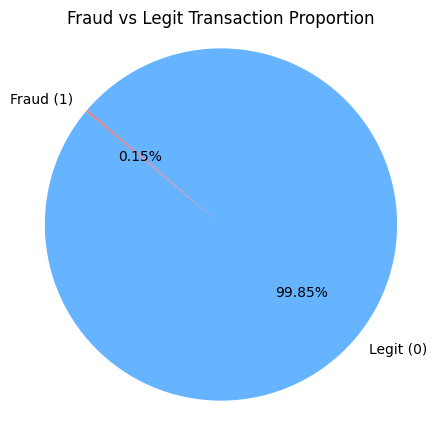

In [11]:
plt.figure(figsize=(5, 5))
plt.pie(fraud_counts, labels=['Legit (0)', 'Fraud (1)'], autopct='%1.2f%%', colors=['#66b3ff', '#ff6666'], startangle=140)
plt.title("Fraud vs Legit Transaction Proportion")
plt.axis('equal')
plt.show()


##  Step 6: Transaction Amount Analysis

### Step 6.1: Basic Stats and Distribution

Transaction Amount Summary:
count     : 8,914,963.00
mean      : 42.95
std       : 81.53
min       : -500.00
25%       : 8.93
50%       : 28.99
75%       : 63.68
max       : 6,613.44


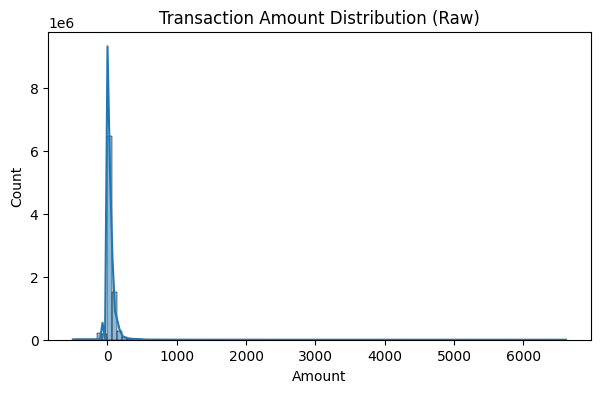

In [15]:
import numpy as np

print("Transaction Amount Summary:")
stats = df['amount'].describe()
for stat, value in stats.items():
    print(f"{stat:<10}: {value:,.2f}")

# Plot raw amount distribution (very skewed)
plt.figure(figsize=(7, 4))
sns.histplot(df['amount'], bins=100, kde=True)
plt.title("Transaction Amount Distribution (Raw)")
plt.xlabel("Amount")
plt.show()

The transaction amounts range from **-$500** to over **$6,600**, with:
- A **mean** of ~$42.95
- A **median** of ~$28.99
- A **long right tail**, suggesting some very high-value outliers
- A **negative minimum**, which may indicate refunds or errors

The raw distribution is extremely right-skewed. To better visualize the spread and reduce the influence of outliers, we apply a log transformation using `log(amount + 1)`.


## Step 6.2: Log-Transformed Distribution

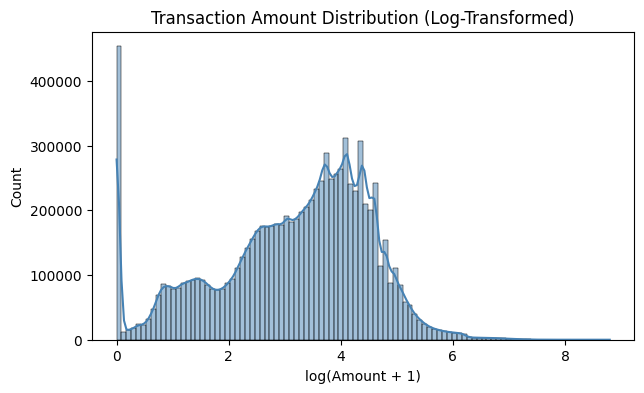

In [16]:
# Create a new column for log-transformed amount
df['log_amount'] = df['amount'].apply(lambda x: np.log1p(x) if x > 0 else 0)

# Plot log-transformed histogram
plt.figure(figsize=(7, 4))
sns.histplot(df['log_amount'], bins=100, kde=True, color='steelblue')
plt.title("Transaction Amount Distribution (Log-Transformed)")
plt.xlabel("log(Amount + 1)")
plt.ylabel("Count")
plt.show()

The log-transformed distribution reveals:
- A large cluster of **very low-value transactions** (near $0–$1)
- Most transactions fall between **$7 and $150**
- A long tail of high-value transactions (> $400) remains, but is now visible
This transformation makes the distribution more interpretable and suitable for modeling.


## Step 6.3: Compare Fraud vs Legit Transactions

### Boxplot (Fraud vs Amount)

C:\Users\HARMEET SINGH\AppData\Local\Temp\ipykernel_16852\3997761594.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='fraud_label', y='log_amount', data=df, palette='Set3')


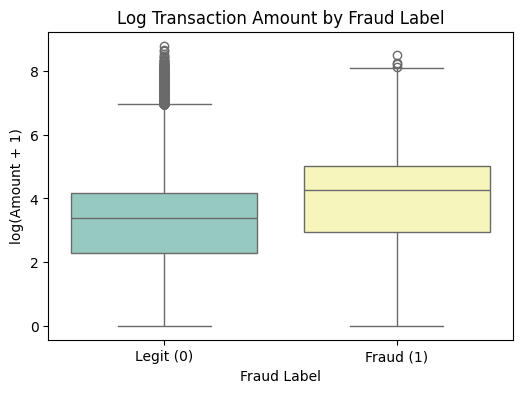

In [17]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='fraud_label', y='log_amount', data=df, palette='Set3')
plt.title("Log Transaction Amount by Fraud Label")
plt.xticks([0, 1], ['Legit (0)', 'Fraud (1)'])
plt.xlabel("Fraud Label")
plt.ylabel("log(Amount + 1)")
plt.show()


### Fraud vs Legit Transactions: Amount Comparison

The boxplot below compares log-transformed transaction amounts between legitimate and fraudulent transactions.

**Insights:**
- Fraudulent transactions tend to have a **higher median amount** than legitimate ones.
- Fraud transactions are also **more consistent** (tighter IQR), suggesting that fraudsters may follow patterns.
- Legitimate transactions show **more variation**, including many low-value transactions and wider outliers.

This indicates that **transaction amount** is a potentially valuable feature for fraud detection.


##  Step 7: Merchant & MCC Analysis

### Step 7.1: Top MCC Categories by Transaction Volume

C:\Users\HARMEET SINGH\AppData\Local\Temp\ipykernel_16852\2230525600.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_mcc.values, y=top_mcc.index, palette='viridis')


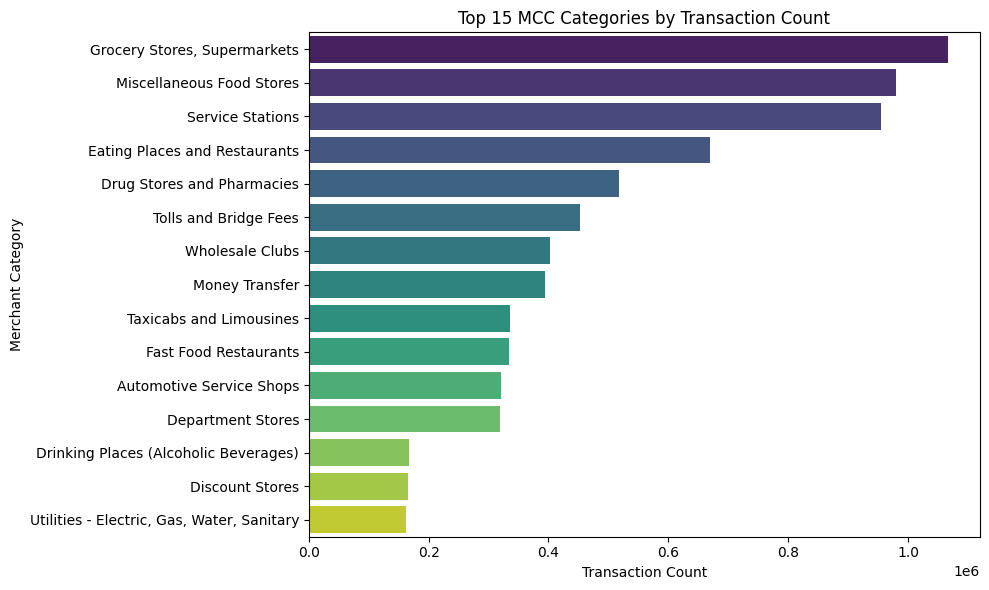

In [18]:
top_mcc = df['mcc_desc'].value_counts().head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_mcc.values, y=top_mcc.index, palette='viridis')
plt.title("Top 15 MCC Categories by Transaction Count")
plt.xlabel("Transaction Count")
plt.ylabel("Merchant Category")
plt.tight_layout()
plt.show()


### Most Common Merchant Categories

The majority of transactions occur in essential, high-frequency categories such as:
- Grocery stores
- Fuel/service stations
- Restaurants
- Pharmacies

These likely reflect legitimate consumer activity.

However, categories like **Money Transfer**, **Taxicabs and Limousines**, and **Tolls** might warrant deeper fraud analysis due to their known association with certain fraud patterns.


### Step 7.2: Fraud Rate by MCC Category

C:\Users\HARMEET SINGH\AppData\Local\Temp\ipykernel_16852\388366611.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mcc_fraud_rate.values, y=mcc_fraud_rate.index, palette='magma')


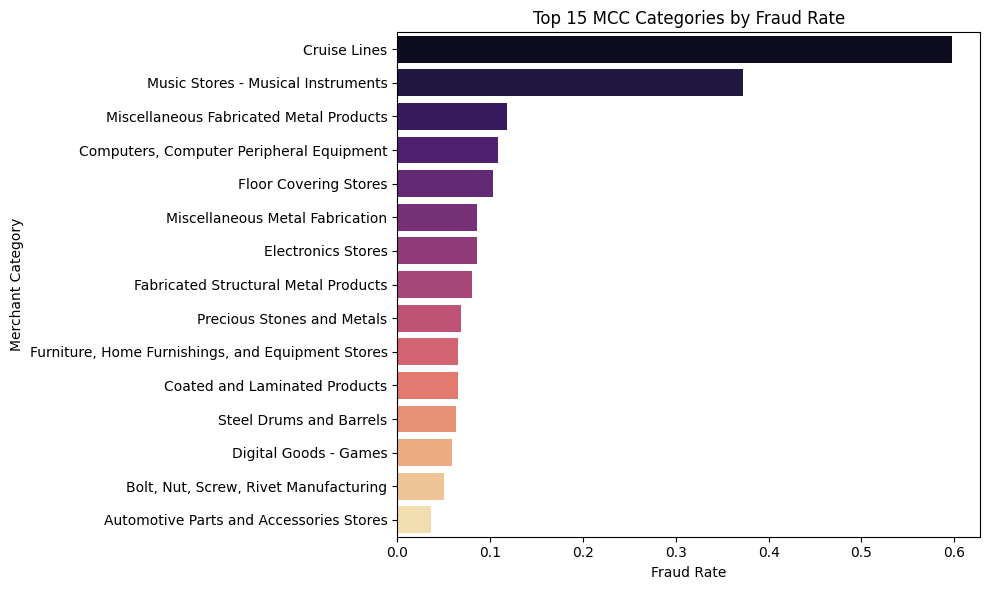

In [19]:
# Calculate fraud rate per MCC category
mcc_fraud_rate = df.groupby('mcc_desc')['fraud_label'].mean().sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x=mcc_fraud_rate.values, y=mcc_fraud_rate.index, palette='magma')
plt.title("Top 15 MCC Categories by Fraud Rate")
plt.xlabel("Fraud Rate")
plt.ylabel("Merchant Category")
plt.tight_layout()
plt.show()


### MCC Categories with the Highest Fraud Rates

This analysis highlights merchant categories with the highest fraud risk, regardless of how common they are.

**Key insights:**
- Fraud is concentrated in **high-value or resellable categories** like Cruise Lines, Electronics, and Precious Metals.
- Everyday categories like Grocery Stores and Restaurants do not appear here, indicating **low fraud risk** despite high volume.

## Step 7.3: MCC Volume vs. Fraud Rate (Scatter Plot)

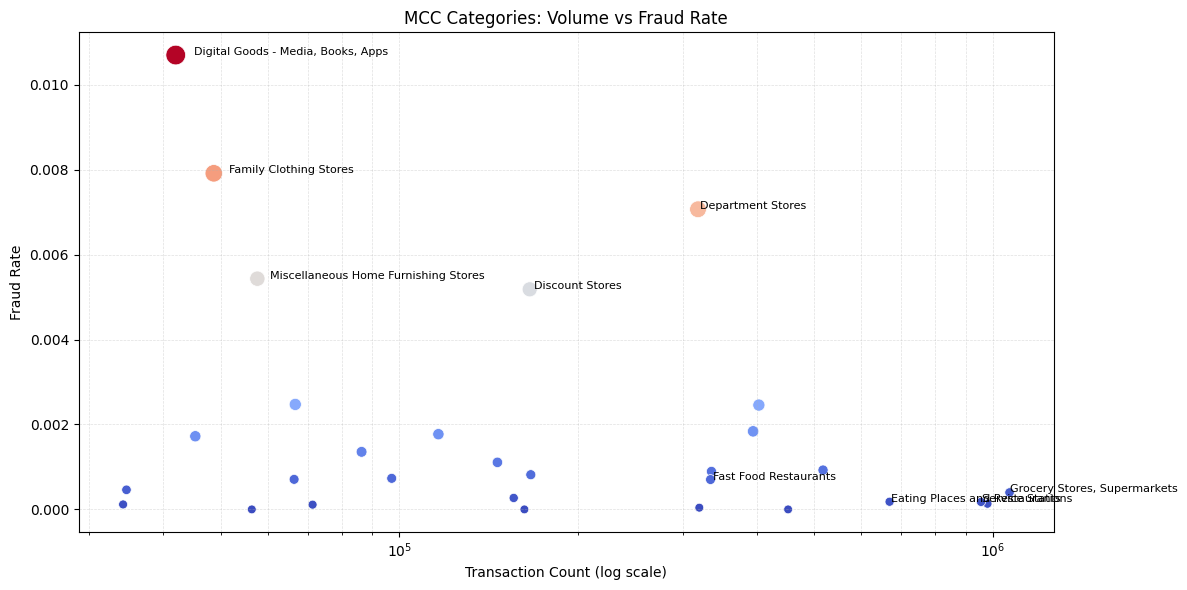

In [22]:
mcc_stats = df.groupby('mcc_desc').agg(
    transaction_count=('id', 'count'),
    fraud_rate=('fraud_label', 'mean')
).sort_values('transaction_count', ascending=False).head(30).reset_index()

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=mcc_stats,
    x='transaction_count',
    y='fraud_rate',
    hue='fraud_rate',
    palette='coolwarm',
    size='fraud_rate',
    sizes=(40, 200),
    legend=False
)

# Label both high-risk and key low-risk categories
low_risk_keywords = ['Grocery', 'Service Station', 'Restaurant']

for i, row in mcc_stats.iterrows():
    label = False

    # Label if fraud rate is high
    if row['fraud_rate'] > 0.0025:
        label = True

    # Label if it's an essential, high-volume category
    for keyword in low_risk_keywords:
        if keyword.lower() in row['mcc_desc'].lower():
            label = True

    if label:
        plt.text(
            row['transaction_count'] + 3000,
            row['fraud_rate'],
            row['mcc_desc'],
            fontsize=8,
            color='black'
        )

plt.xscale("log")
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.4)
plt.title("MCC Categories: Volume vs Fraud Rate")
plt.xlabel("Transaction Count (log scale)")
plt.ylabel("Fraud Rate")
plt.tight_layout()
plt.show()

### MCC: Volume vs. Fraud Rate

This scatterplot highlights merchant categories based on their transaction volume and fraud rate.

**Insights:**
- Categories like **Digital Goods** and **Family Clothing** have high fraud rates despite lower volume.
- **Department Stores** stand out as both high-volume and high-risk — a key target for fraud detection.
- Most essential services (e.g., groceries, gas) have low fraud rates, aligning with earlier findings.

This supports using MCC codes as a strong categorical signal in our model.


## Step 8: User-Level Analysis

### Step 8.1: Age Distribution vs Fraud

C:\Users\HARMEET SINGH\AppData\Local\Temp\ipykernel_16852\2646262685.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='fraud_label', y='current_age', data=df, palette='pastel')


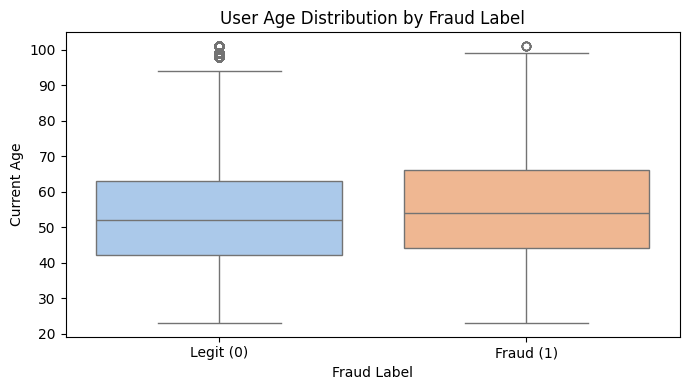

In [23]:
plt.figure(figsize=(7, 4))
sns.boxplot(x='fraud_label', y='current_age', data=df, palette='pastel')
plt.title("User Age Distribution by Fraud Label")
plt.xlabel("Fraud Label")
plt.ylabel("Current Age")
plt.xticks([0, 1], ['Legit (0)', 'Fraud (1)'])
plt.tight_layout()
plt.show()


### Age Distribution by Fraud Label

- Fraudulent transactions are slightly more common among **older users** (median ~53 vs ~50).
- Legitimate transactions show more variation in younger age ranges.
- While age alone may not strongly predict fraud, it could enhance model performance when used in combination with credit or behavioral features.


### Step 8.2: Income Distribution (log scale)

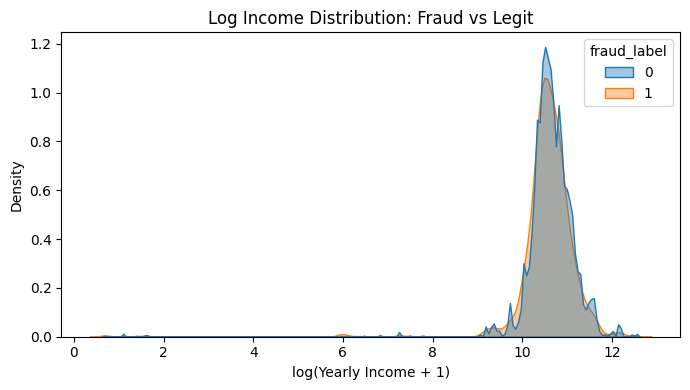

In [24]:
df['log_income'] = df['yearly_income'].apply(lambda x: np.log1p(x) if x > 0 else 0)

plt.figure(figsize=(7, 4))
sns.kdeplot(data=df, x='log_income', hue='fraud_label', common_norm=False, fill=True, alpha=0.4)
plt.title("Log Income Distribution: Fraud vs Legit")
plt.xlabel("log(Yearly Income + 1)")
plt.tight_layout()
plt.show()


### Yearly Income Distribution: Fraud vs Legit

- Fraudulent users show a **slight concentration in higher income brackets** (log > 11 ≈ $60K+).
- Income distribution is **very similar** between fraud and legit users, indicating it may not be a strong standalone predictor.
- However, combining income with features like credit score or number of cards may improve fraud detection.


### Step 8.3: Credit Score vs Fraud (Boxplot)

C:\Users\HARMEET SINGH\AppData\Local\Temp\ipykernel_16852\178616065.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='fraud_label', y='credit_score', data=df, palette='Set2')


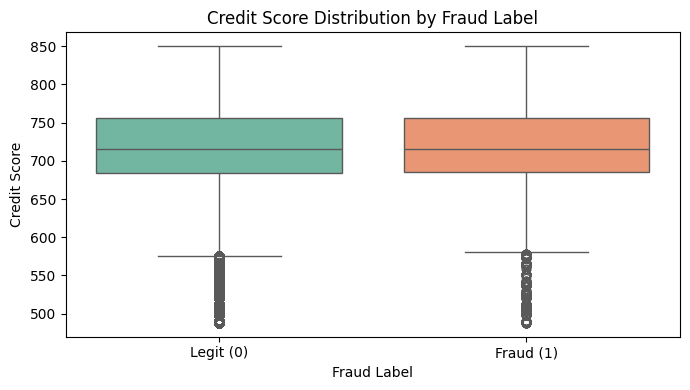

In [25]:
plt.figure(figsize=(7, 4))
sns.boxplot(x='fraud_label', y='credit_score', data=df, palette='Set2')
plt.title("Credit Score Distribution by Fraud Label")
plt.xlabel("Fraud Label")
plt.ylabel("Credit Score")
plt.xticks([0, 1], ['Legit (0)', 'Fraud (1)'])
plt.tight_layout()
plt.show()

### Credit Score Distribution by Fraud Label

- Credit score distributions are very similar for both fraud and legitimate users.
- Median scores in both groups fall around **720–725**, indicating fraud is not exclusive to low-credit individuals.
- This suggests credit score is **not a strong standalone fraud indicator**, but may be useful when combined with income, age, or behavior-based features.


## Step 9: Card-Level Analysis

### Step 9.1: Number of Credit Cards vs Fraud (Boxplot)

C:\Users\HARMEET SINGH\AppData\Local\Temp\ipykernel_16852\1300167969.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='fraud_label', y='num_credit_cards', data=df, palette='Set2')


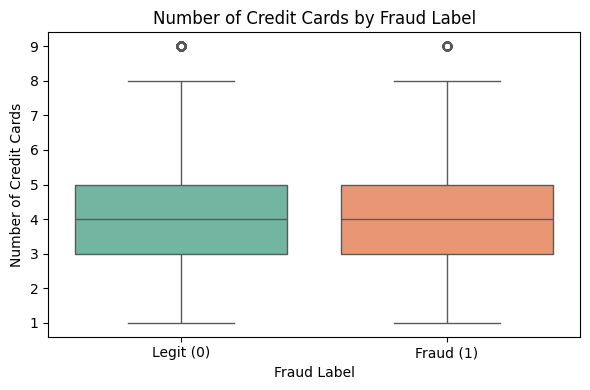

In [26]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='fraud_label', y='num_credit_cards', data=df, palette='Set2')
plt.title("Number of Credit Cards by Fraud Label")
plt.xlabel("Fraud Label")
plt.ylabel("Number of Credit Cards")
plt.xticks([0, 1], ['Legit (0)', 'Fraud (1)'])
plt.tight_layout()
plt.show()


### Number of Credit Cards by Fraud Label

- Legitimate and fraudulent users have **similar card count distributions** (median ~4).
- Fraud does not increase with the number of cards, indicating **no strong standalone correlation**.
- However, this feature may still be useful when combined with behavioral signals or card types.


### Step 9.2: Fraud Rate by Card Brand

C:\Users\HARMEET SINGH\AppData\Local\Temp\ipykernel_16852\4082536311.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_rate_by_brand.values, y=fraud_rate_by_brand.index, palette='coolwarm')


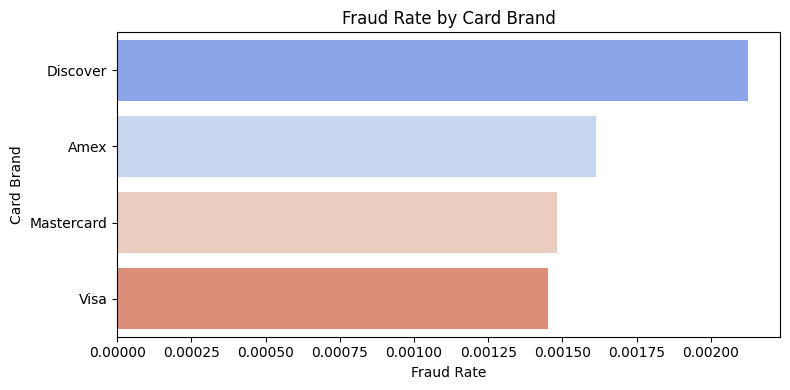

In [27]:
fraud_rate_by_brand = df.groupby('card_brand')['fraud_label'].mean().sort_values(ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(x=fraud_rate_by_brand.values, y=fraud_rate_by_brand.index, palette='coolwarm')
plt.title("Fraud Rate by Card Brand")
plt.xlabel("Fraud Rate")
plt.ylabel("Card Brand")
plt.tight_layout()
plt.show()



### Fraud Rate by Card Brand

- **Discover cards** show the highest fraud rate, suggesting they may be more vulnerable or targeted.
- **Amex** cards also show moderately elevated risk.
- **Visa and Mastercard**, while widely used, have relatively lower fraud rates.

Card brand is a useful feature for modeling fraud, especially when combined with transaction type and amount.


### Step 9.3: Card Type vs Fraud (Bar Plot)

C:\Users\HARMEET SINGH\AppData\Local\Temp\ipykernel_16852\3844517147.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_rate_by_type.values, y=fraud_rate_by_type.index, palette='magma')


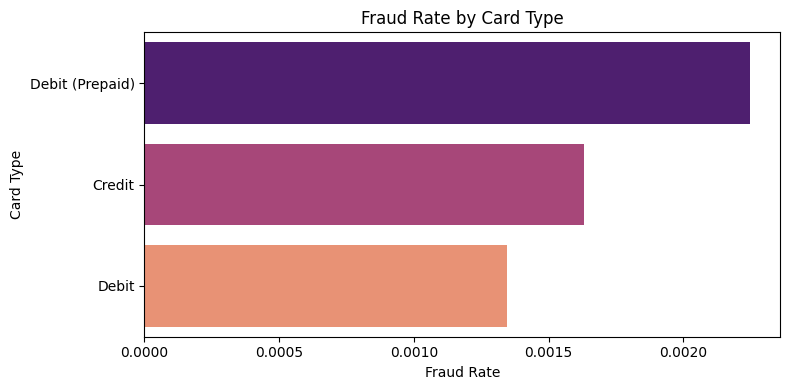

In [28]:
fraud_rate_by_type = df.groupby('card_type')['fraud_label'].mean().sort_values(ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(x=fraud_rate_by_type.values, y=fraud_rate_by_type.index, palette='magma')
plt.title("Fraud Rate by Card Type")
plt.xlabel("Fraud Rate")
plt.ylabel("Card Type")
plt.tight_layout()
plt.show()


### Fraud Rate by Card Type

- **Prepaid debit cards** show the highest fraud rate, likely due to their anonymity and ease of misuse.
- **Credit cards** carry moderate fraud risk.
- **Standard debit cards** show the lowest fraud rate.

Card type provides valuable signal for fraud detection and can be used to flag high-risk payment methods.


### Step 9.4: Use of Chip vs Fraud

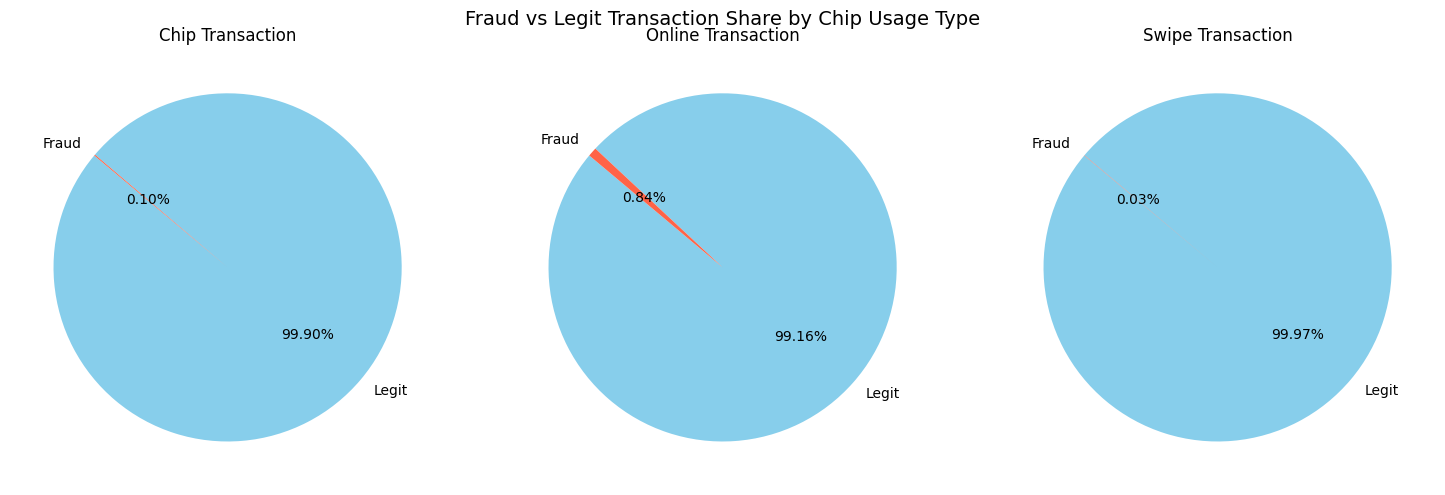

In [32]:
# Pie plots for each 'use_chip' category
chip_groups = df.groupby('use_chip')['fraud_label'].value_counts(normalize=True).unstack().fillna(0)

labels = ['Legit', 'Fraud']
colors = ['skyblue', 'tomato']

# Plot pie chart for each chip type
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, len(chip_groups), figsize=(15, 5))
for i, chip_type in enumerate(chip_groups.index):
    axs[i].pie(
        chip_groups.loc[chip_type],
        labels=labels,
        autopct='%1.2f%%',
        colors=colors,
        startangle=140
    )
    axs[i].set_title(f"{chip_type}")

fig.suptitle("Fraud vs Legit Transaction Share by Chip Usage Type", fontsize=14)
plt.tight_layout()
plt.show()



### Fraud by Chip Usage Type

- **Online transactions** carry the highest fraud risk (0.84%), far more than chip (0.10%) or swipe (0.03%) transactions.
- **Chip transactions** are the most secure, likely due to EMV encryption and card-present validation.
- **Swipe transactions** show very low fraud, possibly due to reduced usage.

This reinforces chip and swipe as safer channels, while highlighting online payments as a key fraud vector to monitor.


## Step 10: Fraud Rate by Zip Code (Top 15)

C:\Users\HARMEET SINGH\AppData\Local\Temp\ipykernel_16852\3668975833.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_zips['fraud_rate'], y=top_zips.index.astype(str), palette='magma')


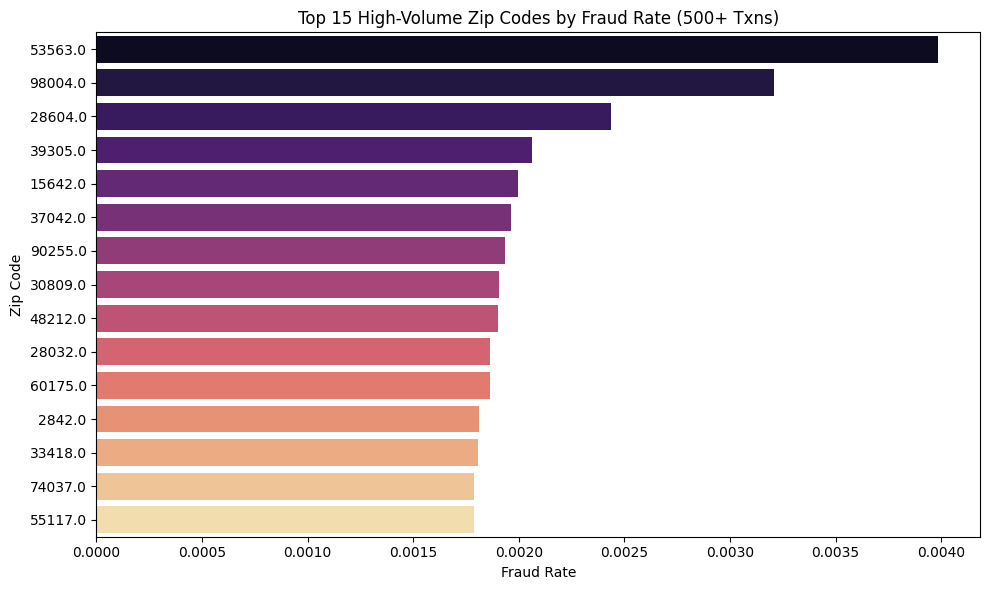

In [36]:
import seaborn as sns

# Drop NaN zips if any
df_zip = df.dropna(subset=['zip'])

# Zip-level fraud analysis with volume filter
zip_stats = df_zip.groupby('zip').agg(
    total_txns=('fraud_label', 'count'),
    fraud_rate=('fraud_label', 'mean')
)

# Filter out low volume zips
zip_stats = zip_stats.query('total_txns >= 500')

# Top 15 by fraud rate
top_zips = zip_stats.sort_values('fraud_rate', ascending=False).head(15)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_zips['fraud_rate'], y=top_zips.index.astype(str), palette='magma')
plt.title("Top 15 High-Volume Zip Codes by Fraud Rate (500+ Txns)")
plt.xlabel("Fraud Rate")
plt.ylabel("Zip Code")
plt.tight_layout()
plt.show()


### Zip Code-Level Fraud Risk

- Top zip codes such as **53563** and **98004** show fraud rates **2–3× higher than average**, despite high transaction volume.
- This suggests **regional fraud concentration**, likely driven by socioeconomic or behavioral patterns.
- Zip code is a valuable geolocation feature and may support risk-based fraud scoring.


In [3]:
import pandas as pd

df = pd.read_parquet("../artifacts/model_input.parquet")

# 1. Check basic info
print("🔍 Shape:", df.shape)
print("🧠 Target classes:", df['fraud_label'].value_counts())

# 2. Look at column name patterns
print("\n📌 Sample columns:")
print(df.columns[:20].tolist())

# 3. Check for duplicates
dupes = df.columns[df.columns.duplicated()].tolist()
if dupes:
    print("❌ Duplicate columns:", dupes)
else:
    print("✅ No duplicate columns found.")

# 4. Check object (non-numeric) columns
non_numeric = df.select_dtypes(include='object').columns.tolist()
if non_numeric:
    print("⚠️ Non-numeric columns:", non_numeric)
else:
    print("✅ All features are numeric.")


🔍 Shape: (8914963, 213)
🧠 Target classes: fraud_label
0    8901631
1      13332
Name: count, dtype: int64

📌 Sample columns:
['log_amount', 'log_income', 'credit_score', 'num_credit_cards', 'debt_to_income', 'amount_to_limit_ratio', 'is_high_amount', 'use_chip_Chip Transaction', 'use_chip_Online Transaction', 'use_chip_Swipe Transaction', 'card_type_Credit', 'card_type_Debit', 'card_type_Debit (Prepaid)', 'merchant_state_AA', 'merchant_state_AK', 'merchant_state_AL', 'merchant_state_AR', 'merchant_state_AZ', 'merchant_state_Albania', 'merchant_state_Algeria']
✅ No duplicate columns found.
✅ All features are numeric.


In [1]:
df[df['merchant_state_Italy'] == 1]['fraud_label'].value_counts(normalize=True)


NameError: name 'df' is not defined